# 2017-06-08 - For discussion concerning mcmcplotlib
by Ari Hartikainen  
[@ahartikainen](https://github.com/ahartikainen)


## Suggestion: Plotdata generating functions for mcmcplotlib

- generic functions that are fast, scalable (large trace, one machine) and create a plottable (x,y) data with plot specific metadata
- plotting libraries (matplotlib, bokeh) plot the results
- currently only numpy (for plot generating function) and matplotlib (only for examples) needs to be imported

### Here are the examples of the generic functions
- histogram
    - numpy.histogram function for calculation
    - pyplot.bar / pyplot.step for plotting (example)
- kde (violin can be also calculated)
    - numpy.fft based convolution for large data with boundary corrections
        - works OK for small data
    - implemented gaussian kernel (following scipy)
    - violin plot by reversing kde result (with y-base on 0)
- autocorrelation / crosscorrelation
    - numpy.fft based correlation
    - is currently biased (is this problem?)
- forest plot
    - quick mockup, missing some functionality and metadata

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Data creation (array size 500k)

In [2]:
%%time
arr_float = np.random.randn(500000) + 2*np.sin(np.linspace(1.1, 14, 500000))
arr_int = (np.random.randint(12, 20, 500000) + 2*np.sin(np.linspace(1.1, 14, 500000))).astype('int')
arr_float_const = np.random.uniform(0,13,500000)

Wall time: 140 ms


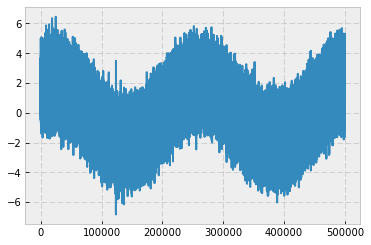

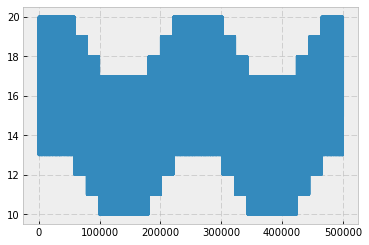

In [3]:
plt.plot(arr_float)
plt.figure()
plt.plot(arr_int)

# HISTOGRAM AND KDE

In [4]:
def hist_op(arr, bins=100, hist_type='i', **kwargs):
    if hist_type is 'i':
        arrmin, arrmax = np.min(arr), np.max(arr)
        bins = range(arrmin, arrmax + 2, max((arrmax - arrmin) // bins, 1))
    if 'density' not in kwargs:
        kwargs['density'] = True
    hist, edges = np.histogram(arr, bins=bins, **kwargs)
    return hist, edges

In [5]:
def kde_op(arr, kernel='gaussian', c=1, int_shift=False):
    
    n = len(arr)
    nx = 200
    
    # bin the data
    arrmin, arrmax = np.min(arr), np.max(arr)
    bins = np.linspace(arrmin, arrmax, nx)
    xyi = np.digitize(arr, bins)
    dx = (arrmax - arrmin) / (nx - 1)
    grid, _ = np.histogram(arr, bins=bins)
    
    scotts_factor = nx ** (-0.2) * c
    
    std_x = np.std(xyi)
    kern_nx = int(scotts_factor*2*np.pi*std_x)
    fft_nx = kern_nx * 3 + kern_nx % 1
    
    # from scipy.signal.gaussian
    def gaussian(M, std):
        N = np.arange(0, M) - (M - 1.0) / 2
        sig2 = 2 * std ** 2
        lw = -N ** 2 / sig2
        return np.exp(lw)
    
    # create a gaussian kernel to convolve the data
    if kernel == 'gaussian':
        kernel = gaussian(fft_nx, scotts_factor*std_x)
    npad = np.min((nx, 2*kern_nx))
    grid = np.r_[grid[npad:0:-1], grid, grid[nx:nx-npad:-1]]
    # following scipy.signal.fftconvolve
    def fftconvolve(grid, kernel):
        shape1 = grid.shape[0]
        shape2 = kernel.shape[0]
        shape = int(shape1 + shape2 - 1)
        
        fft_shape = 2**shape.bit_length()
        fft_slice = slice(0, shape)
        
        fft_grid = np.fft.rfft(grid, fft_shape)
        fft_kernel = np.fft.rfft(kernel, fft_shape)
        fft_product = fft_grid * fft_kernel
        convolved_grid = np.fft.irfft(fft_product, fft_shape)[fft_slice]
        return convolved_grid
    
    # convolve and slice the signal
    grid = fftconvolve(grid, kernel)
    grid_slice = slice(npad+fft_nx//2-1, nx+npad+fft_nx//2-1)
    grid = grid[grid_slice]
    
    # normalize the grid
    norm_factor = n * dx * (2 * np.pi * std_x ** 2 * scotts_factor ** 2) ** 0.5
    grid = grid / norm_factor
    
    # create x-locations for grid points
    x = np.linspace(arrmin, arrmax, nx)
    return x, grid

# Histogram example int

In [6]:
%time H, edges = hist_op(arr_int, bins=50)    

Wall time: 15.6 ms


(0, 0.13177710000000001)

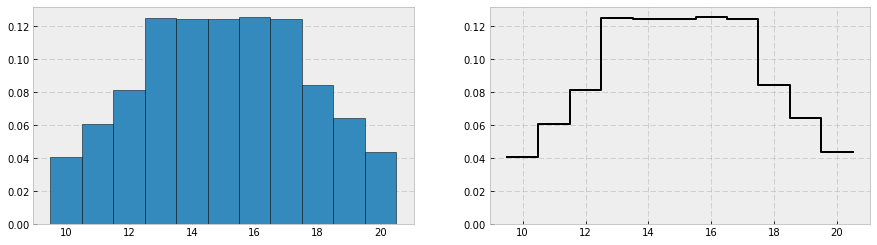

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.bar(edges[:-1], H, width=1, edgecolor='k', zorder=10)
ymax = plt.gca().get_ylim()[1]
plt.grid(False)
plt.grid(True, axis='y')
x = edges - 0.5
y = np.r_[H[0], H]

plt.subplot(122)
plt.step(x, y, color='k')
plt.ylim(0, ymax)

## Histogram / kde example

#### kde has problems with integer sized data

- probably not solvable without some clever data manipulation with bin locations (shift 0.5)
- not currently implemented

In [8]:
%time x, y = kde_op(arr_int) # Scott's rule
%time x_, y_ = kde_op(arr_int, c=0.7) # Scott's rule * 0.7

Wall time: 78 ms
Wall time: 78 ms


<Container object of 11 artists>

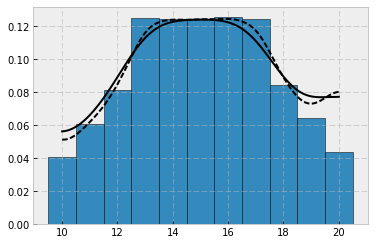

In [9]:
plt.plot(x, y, color='k')
plt.plot(x_, y_, color='k', ls='--')
#plt.fill_between(x, y)
plt.bar(edges[:-1], H, width=1, edgecolor='k')

# Histogram example float

In [10]:
%time Hf, edgesf = hist_op(arr_float, hist_type='f', bins=50)    

Wall time: 15.6 ms


(0, 0.20229239263919657)

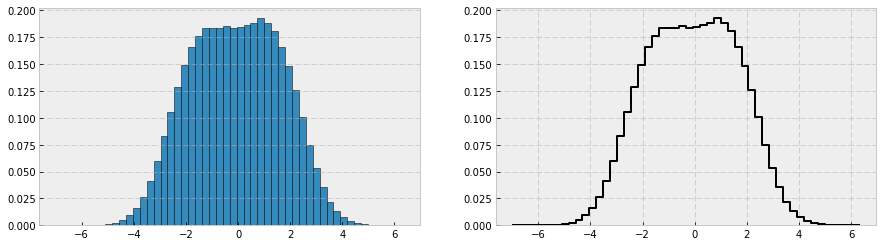

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(121)

xw = edgesf[1]-edgesf[0]
plt.bar(edgesf[:-1], Hf, width=xw, edgecolor='k')
ymax = plt.gca().get_ylim()[1]
plt.grid(False)
plt.grid(True, axis='y')


plt.subplot(122)
x = edgesf - xw/2
y = np.r_[Hf[0], Hf]

plt.step(x, y, color='k')
plt.ylim(0, ymax)

# KDE example float

In [12]:
%time x, y = kde_op(arr_float)  # Scott's rule
%time x_, y_ = kde_op(arr_float, c=0.3)  # Scott's rule * 0.3
# Scott's rule is not optimal, maybe we can get a better estimator (something that is function of n and array properties)

Wall time: 93.6 ms
Wall time: 109 ms


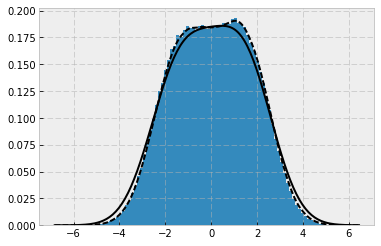

In [13]:
plt.plot(x, y, color='k')
plt.plot(x_, y_, color='k', ls='--')
#plt.fill_between(x, y)
plt.hist(arr_float, normed=True, bins=100);

In [14]:
%time x, y = kde_op(arr_float_const) # uniform dist

Wall time: 93.6 ms


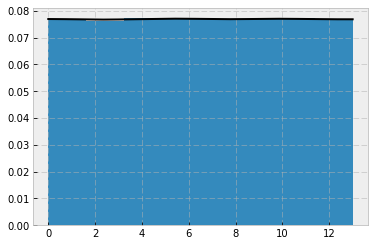

In [15]:
plt.plot(x, y, color='k')
#plt.fill_between(x, y)
plt.hist(arr_float_const, bins=8, normed=True);

# Autocorr

In [16]:
def correlate(arr1, arr2=None):
    if arr2 is None:
        arr1 = np.asarray(arr1) - np.mean(arr1)
        n = arr1.shape[0]
        shape = int(2 * n)
        
        fft_shape = 2 ** shape.bit_length()
        fft_slice = slice(0, n)
        
        fft_arr = np.fft.rfft(arr1, fft_shape)
        fft_product = fft_arr * np.conjugate(fft_arr)
        
        normalization = arr1.dot(arr1)
    else:
        mean_arr1 = np.mean(arr1)
        mean_arr2 = np.mean(arr2)
        arr1 = np.asarray(arr1) - mean_arr1
        arr2 = np.asarray(arr2) - mean_arr2
                                          
        n1 = arr1.shape[0]
        n2 = arr2.shape[0]
        shape = int(n1 + n2)

        fft_shape = 2 ** shape.bit_length()
        fft_slice = slice(0, min(n1, n2))

        fft_arr1 = np.fft.rfft(arr1, fft_shape)
        fft_arr2 = np.fft.rfft(arr2, fft_shape)
        if n1 < n2:
            fft_product = fft_arr1.conj() * fft_arr2
        else:
            fft_product = fft_arr1 * fft_arr2.conj()
        #print(fft_product)
        
        std_arr1 = arr1.std()
        std_arr2 = arr2.std()
        
        n = min(n1, n2)
        normalization = n * std_arr1 * std_arr2
        
    corr_arr = np.fft.irfft(fft_product, fft_shape)
    corr_arr = corr_arr[fft_slice] / normalization
    return corr_arr

- current results are biased
- unbias correction not implemented (weighting tail too much)

In [17]:
%%time
autocorr_arr = correlate(arr_float)
autocorr_arr2 = correlate(arr_float, arr_float)
autocorr_arr3 = correlate(arr_float, -arr_float)
autocorr_arr4 = correlate(arr_float, arr_float[150000:])
autocorr_arr5 = correlate(arr_float[100000:], arr_float)
cross_corr = correlate(arr_float, np.random.randn(1500000))

Wall time: 2.5 s


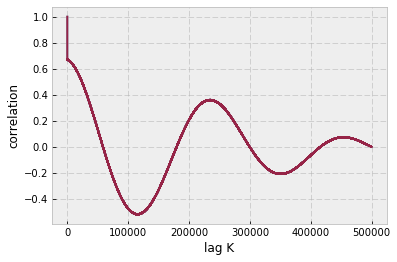

In [18]:
plt.plot(autocorr_arr, alpha=0.8)
plt.plot(autocorr_arr2, alpha=0.8)
plt.xlabel('lag K')
plt.ylabel('correlation')

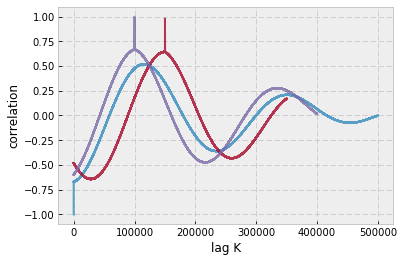

In [19]:
plt.plot(autocorr_arr3, alpha=0.8)
plt.plot(autocorr_arr4, alpha=0.8)
plt.plot(autocorr_arr5, alpha=0.8)
plt.xlabel('lag K')
plt.ylabel('correlation')

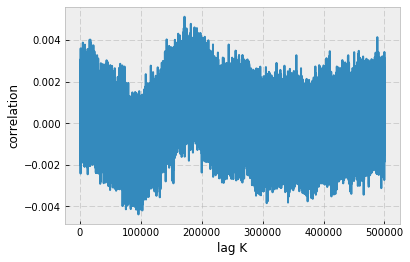

In [20]:
plt.plot(cross_corr)
plt.xlabel('lag K')
plt.ylabel('correlation')

# Forest plot

In [21]:
def forestplot_op(arr, h=0, method='point_quantiles', point='median', quantiles=[0.25, 0.75], horizontal=True):
    """
    input
        arr = 1D array of values
        i = location on orthogonal axis y (horizontal=True) or x (horizontal=False)
        method = point_quantiles (default)
                 point
                 quantiles
                 kde
                 kde_point
                 kde_point_quantiles
                 violin
                 violin_point
                 violin_point_quantiles
        point = 'median'
                'mean'
                'quantile' = this assumes that quantiles have atleast three parameters and len is odd
                function reading 1D numpy array returning a value
        quantiles = two or mode quantile points  0 < q_i < 1
                    IQR = [0.25, 0.75] (default)
                    std = mean-std, mean+std
                    xstd = mean-std*x, mean+std*x
        horizontal = True    data values in changing in horizontal direction
    output
        dictionary = data
                     method
                     meta
    """
    
    # create output dictionaries
    output = {}
    output_data_dict = {}
    output['method'] = method
    output['meta'] = {}
    output['meta']['horizontal'] = horizontal
    
    # handle point
    if 'point' in method:
        if point == 'median':
            point_value = np.median(arr)
        elif point == 'mean':
            point_value = np.mean(arr)
        elif point == 'quantile':
            assert(len(quantiles) > 2 and len(quantiles) % 2 != 0)
            point_value = np.percentile(arr, quantiles[len(quantiles)//2])
        else:
            point_value = point(arr)
        
        # Insert into output_data_dict
        if horizontal:
            output_data_dict['point'] = [point_value], [h], point
        else:
            output_data_dict['point'] = [h], [point_value], point
    
    # handle quantiles
    if 'quantiles' in method:
        if point == 'quantile':
            quantiles_levels = np.concatenate(quantiles[:len(quantiles)//2], quantiles[len(quantiles)//2+1])
        if isinstance(quantiles, str):
            if 'iqr' == quantiles.lower():
                quantiles_levels = np.array(0.25, 0.75)
                quantile_values = np.percentile(arr, quantiles_levels*100)
            elif 'std' == quantiles.lower():
                marr = np.mean(arr)
                std_arr = np.std(arr, ddof=1)
                quantile_values = np.array([marr-std_arr, marr+std_arr])
            elif 'std' in quantiles.lower():
                c = np.float(quantiles.lower().replace('std', ''))
                marr = np.mean(arr)
                std_arr = np.std(arr, ddof=1)
                quantile_values = np.array([marr-std_arr*c, marr+std_arr*c])
        else:
            quantiles_levels = np.array(quantiles)
            quantile_values = np.percentile(arr, quantiles_levels*100)
        
        # Insert into output_data_dict
        if horizontal:
            output_data_dict['quantile'] = quantile_values, np.ones_like(quantile_values)*h, quantiles
        else:
            output_data_dict['quantile'] = np.ones_like(quantile_values)*h, quantile_values, quantiles
        
    if 'kde' in method or 'violin' in method:
        kdex0, kdey0 = kde_op(arr)
        
        # normalize to one
        kdey0 /= kdey0.max() 
        kdey0 *= 0.9
        
        if 'violin' in method:
            kdex1 = kdex0
            # transform to 0.5
            kdey0 /= 2
            kdey1 = -kdey0
            kdey0 += h
            kdey1 += h            
        else:
            kdey0 += h
            kdex1 = []
            kdey1 = []
            
        if horizontal:
            output_data_dict['kde'] = (kdex0, kdey0), (kdex1, kdey1), 'kde' if 'kde' in method else 'violin'
        else:
            output_data_dict['kde'] = (kdey0, kdex0), (kdey1, kdex1), 'kde' if 'kde' in method else 'violin'
    
    output['data'] = output_data_dict
    return output    
    

# Example output

In [22]:
fdict = forestplot_op(arr_float)
fdict

{'data': {'point': ([0.064879020472904447], [0], 'median'),
  'quantile': (array([-1.29626954,  1.39428373]),
   array([ 0.,  0.]),
   [0.25, 0.75])},
 'meta': {'horizontal': True},
 'method': 'point_quantiles'}

In [23]:
fdict = forestplot_op(arr_float, method='kde')
fdict

{'data': {'kde': ((array([-6.82656347, -6.75985894, -6.69315441, -6.62644988, -6.55974535,
           -6.49304082, -6.42633629, -6.35963176, -6.29292723, -6.2262227 ,
           -6.15951817, -6.09281364, -6.02610911, -5.95940457, -5.89270004,
           -5.82599551, -5.75929098, -5.69258645, -5.62588192, -5.55917739,
           -5.49247286, -5.42576833, -5.3590638 , -5.29235927, -5.22565474,
           -5.15895021, -5.09224568, -5.02554115, -4.95883662, -4.89213208,
           -4.82542755, -4.75872302, -4.69201849, -4.62531396, -4.55860943,
           -4.4919049 , -4.42520037, -4.35849584, -4.29179131, -4.22508678,
           -4.15838225, -4.09167772, -4.02497319, -3.95826866, -3.89156413,
           -3.8248596 , -3.75815506, -3.69145053, -3.624746  , -3.55804147,
           -3.49133694, -3.42463241, -3.35792788, -3.29122335, -3.22451882,
           -3.15781429, -3.09110976, -3.02440523, -2.9577007 , -2.89099617,
           -2.82429164, -2.75758711, -2.69088257, -2.62417804, -2.5574735

In [24]:
# this is just helper function for this notebook
def plot_forest(fdict, h=1, quantile_points=True, color=None):
    for key, values in fdict['data'].items():
        if key == 'point':
            x, y, ptype = values
            if 'violin' in fdict['method'] or 'kde' in fdict['method']:
                markersize=5
                pcolor = 'k'
            else:
                markersize=12
                pcolor = color
            plt.plot(x, y, marker='o', markersize=markersize, color=pcolor, lw=0, zorder=12)
        elif key == 'quantile':
            x, y, ptype = values
            if quantile_points:
                if 'violin' in fdict['method'] or 'kde' in fdict['method']:
                    markersize=5
                    pcolor = 'k'
                else:
                    markersize=7
                    pcolor = color
            else:
                markersize=0
            plt.plot(x, y, marker='o', markersize=markersize, color=pcolor, lw=2, zorder=12)
        elif key == 'kde':
            (x, y), (x_, y_), ptype = values
            if ptype == 'kde':
                plt.plot(x, y, lw=1, color=color, zorder=11)
                if fdict['meta']['horizontal']:
                    plt.fill_between(x, y, np.ones_like(y)*h, color=color, zorder=10)
                else:
                    plt.fill_betweenx(y, x, np.ones_like(x)*h, color=color, zorder=10)
            else:
                plt.plot(x, y, lw=1, color=color, zorder=11)
                plt.plot(x_, y_, lw=1, color=color, zorder=11)
                if fdict['meta']['horizontal']:
                    plt.fill_between(x, y, y_, color=color, zorder=10)
                else:
                    plt.fill_betweenx(y, x, x_, color=color, zorder=10)

# Example plots

In [25]:
from string import ascii_lowercase

## Point + quantile lines / points

Wall time: 827 ms


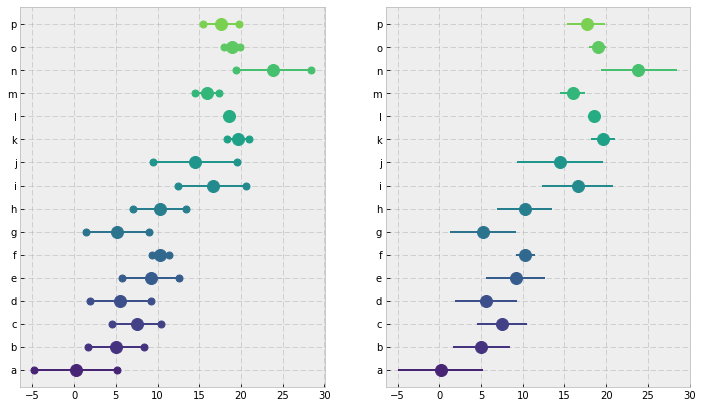

In [26]:
%%time
#create a new figure
plt.figure(figsize=(12, 7))

plt.subplot(121)
for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    # create data
    arr = arr_float * np.random.randn()*3 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    fdict = forestplot_op(arr, i)
    plt.subplot(121)
    plot_forest(fdict, color=color)
    plt.subplot(122)
    plot_forest(fdict, quantile_points=False, color=color)

plt.subplot(121)
plt.yticks(range(16), ascii_lowercase[:16]);
plt.subplot(122)
plt.yticks(range(16), ascii_lowercase[:16]);

## KDE / violin

Wall time: 3.87 s


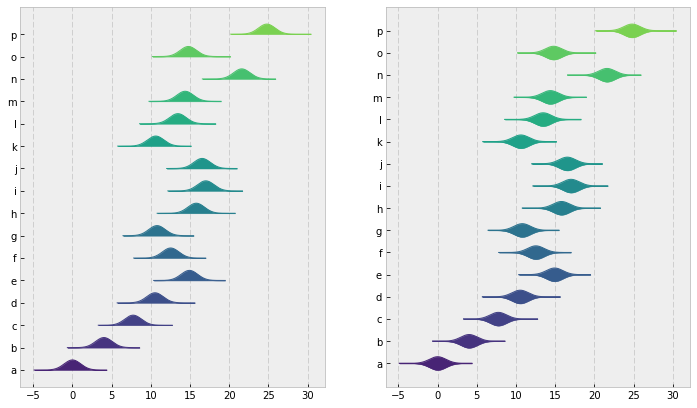

In [27]:
%%time
plt.figure(figsize=(12, 7))
for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    arr = np.random.randn(len(arr_float))*1 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    
    plt.subplot(121)
    fdict = forestplot_op(arr, i*2, method='kde')
    plot_forest(fdict, h=i*2, quantile_points=False, color=color)
    
    plt.subplot(122)
    fdict = forestplot_op(arr, i*1.5, method='violin')
    plot_forest(fdict, h=i*1.5, quantile_points=False, color=color)
    

plt.subplot(121)
plt.yticks(2*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

plt.subplot(122)
plt.yticks(1.5*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

## Point + quantile lines / points vertical

Wall time: 842 ms


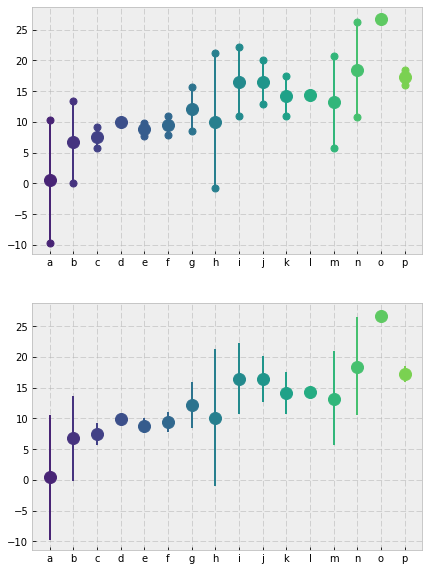

In [28]:
%%time
#create a new figure
plt.figure(figsize=(7, 10))


for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    # create data
    arr = arr_float * np.random.randn()*3 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    fdict = forestplot_op(arr, i, horizontal=False)
    
    plt.subplot(211)
    plot_forest(fdict, color=color)
    
    plt.subplot(212)
    plot_forest(fdict, quantile_points=False, color=color)
    
plt.subplot(211)
plt.xticks(range(16), ascii_lowercase[:16]);

plt.subplot(212)
plt.xticks(range(16), ascii_lowercase[:16]);

## KDE / violin vertical

Wall time: 3.81 s


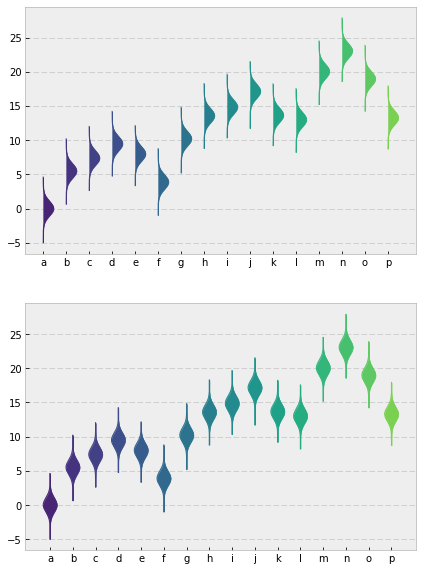

In [29]:
%%time
plt.figure(figsize=(7, 10))
for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    arr = np.random.randn(len(arr_float))*1 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    plt.subplot(211)
    fdict = forestplot_op(arr, i*2, method='kde', horizontal=False)
    plot_forest(fdict, h=i*2, quantile_points=False, color=color)
    
    plt.subplot(212)
    fdict = forestplot_op(arr, i*1.5, method='violin', horizontal=False)
    plot_forest(fdict, h=i*1.5, quantile_points=False, color=color)
    

plt.subplot(211)
plt.xticks(2*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='y')

plt.subplot(212)
plt.xticks(1.5*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='y')

## KDE / violin  + point

Wall time: 3.92 s


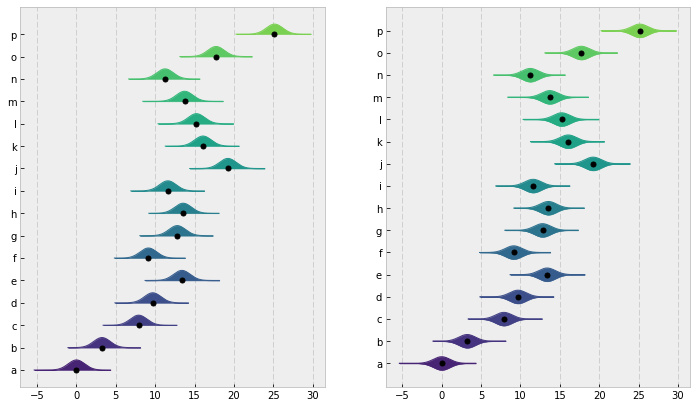

In [30]:
%%time
plt.figure(figsize=(12, 7))
for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    arr = np.random.randn(len(arr_float))*1 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    
    plt.subplot(121)
    fdict = forestplot_op(arr, i*2, method='kde_point', point=np.mean)
    plot_forest(fdict, h=i*2, quantile_points=False, color=color)
    
    plt.subplot(122)
    fdict = forestplot_op(arr, i*1.5, method='violin_point', point=np.mean)
    plot_forest(fdict, h=i*1.5, quantile_points=False, color=color)
    

plt.subplot(121)
plt.yticks(2*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

plt.subplot(122)
plt.yticks(1.5*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

## KDE / violin + point + quantile (90%)

Wall time: 4.32 s


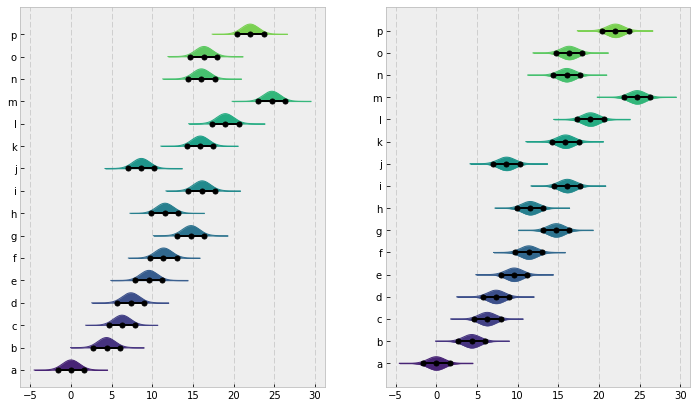

In [31]:
%%time
plt.figure(figsize=(12, 7))
for i, color in zip(range(16), plt.cm.viridis(np.linspace(0.1,0.8,16))):
    arr = np.random.randn(len(arr_float))*1 + np.random.randn()*np.sqrt(i)+np.sqrt(i)*5
    
    plt.subplot(121)
    fdict = forestplot_op(arr, i*2, method='kde_point_quantiles', quantiles=[0.05, 0.95], point=np.mean)
    plot_forest(fdict, h=i*2, quantile_points=True, color=color)
    
    plt.subplot(122)
    fdict = forestplot_op(arr, i*1.5, method='violin_point_quantiles', quantiles=[0.05, 0.95], point=np.mean)
    plot_forest(fdict, h=i*1.5, quantile_points=True, color=color)
    

plt.subplot(121)
plt.yticks(2*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

plt.subplot(122)
plt.yticks(1.5*np.arange(16), ascii_lowercase[:16]);
plt.grid(False)
plt.grid(axis='x')

## Example dict

In [32]:
fdict

{'data': {'kde': ((array([ 17.35348907,  17.39994221,  17.44639534,  17.49284847,
            17.5393016 ,  17.58575474,  17.63220787,  17.678661  ,
            17.72511413,  17.77156727,  17.8180204 ,  17.86447353,
            17.91092666,  17.9573798 ,  18.00383293,  18.05028606,
            18.0967392 ,  18.14319233,  18.18964546,  18.23609859,
            18.28255173,  18.32900486,  18.37545799,  18.42191112,
            18.46836426,  18.51481739,  18.56127052,  18.60772365,
            18.65417679,  18.70062992,  18.74708305,  18.79353618,
            18.83998932,  18.88644245,  18.93289558,  18.97934872,
            19.02580185,  19.07225498,  19.11870811,  19.16516125,
            19.21161438,  19.25806751,  19.30452064,  19.35097378,
            19.39742691,  19.44388004,  19.49033317,  19.53678631,
            19.58323944,  19.62969257,  19.6761457 ,  19.72259884,
            19.76905197,  19.8155051 ,  19.86195823,  19.90841137,
            19.9548645 ,  20.00131763,  20.0477